In [16]:
# importing libraries and set standards
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import statistics as stat

plt.rcParams['figure.figsize'] = 21, 15
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5

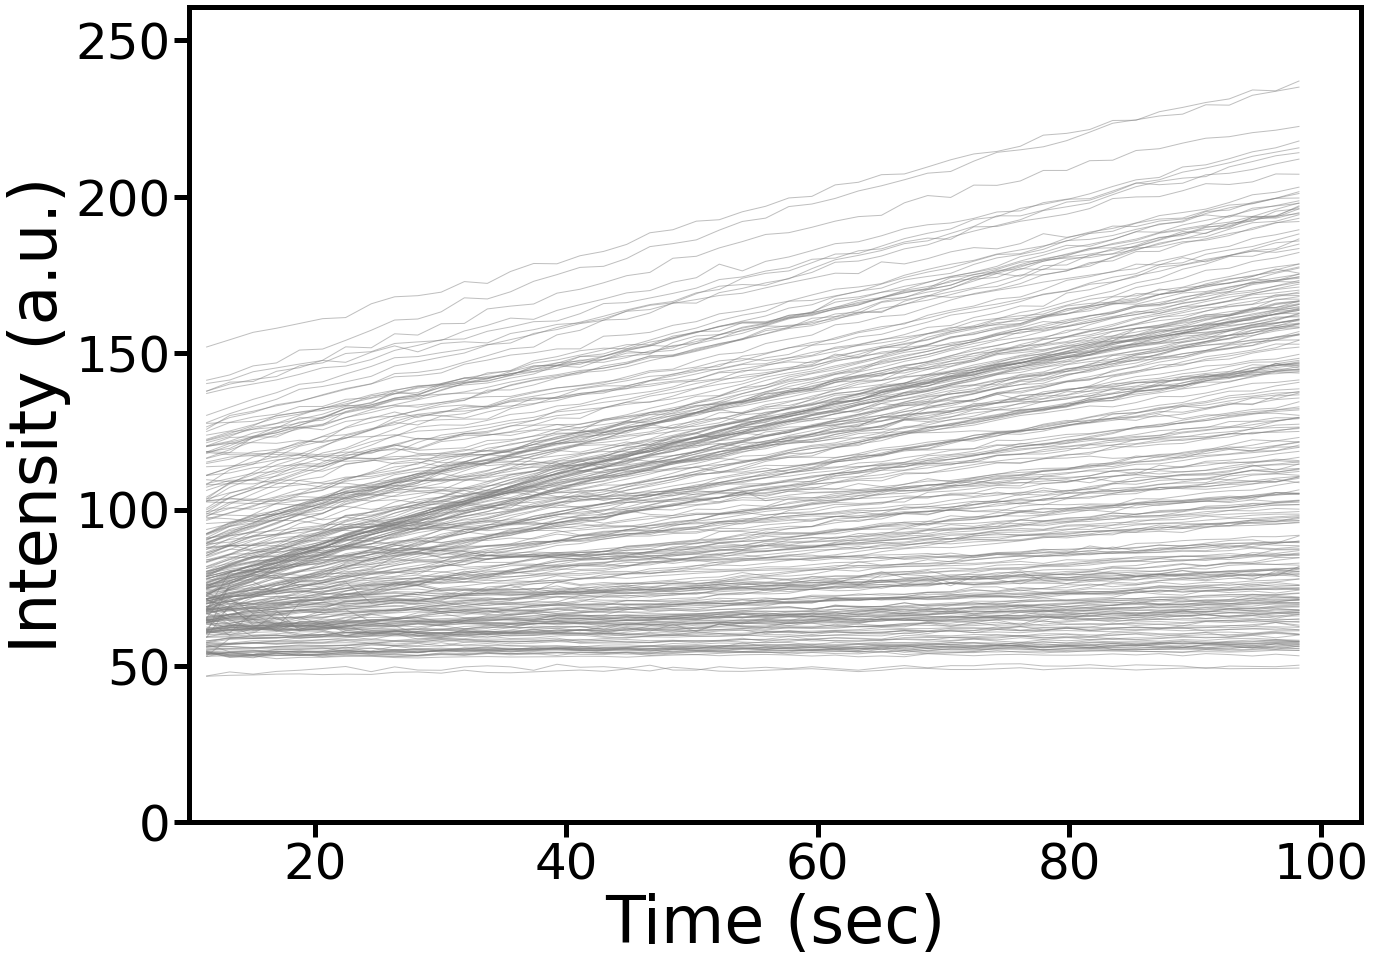

In [17]:
# import csv, get radius once and delete the column
data = pd.read_csv("Kinetics_230210_007.csv", delimiter=';')
time = pd.read_csv("007_Time.csv", delimiter=';')


# rename the columns
data.rename(columns = {'TRACK_ID': 'Droplet_ID', 'POSITION_X': 'X',  'POSITION_Y': 'Y' , 'POSITION_T': 'Time', 'MEAN_INTENSITY_CH1': 'ROX', 'MEAN_INTENSITY_CH3': 'Atto'}, inplace = True)
# group data by Droplet_ID
grouped = data.groupby(data.Droplet_ID)

# create a list of the droplet IDs
ID_list =[]
for i in data.Droplet_ID:
    ID_list.append(i) if i not in ID_list else ID_list
    
    
time_dict = time.set_index('Index').to_dict()['Time [s]']
data['Time'] = data['Time'].map(time_dict).fillna(data['Time'])

#create a list of the droplets, sort by time, normalize Signal and provide time in minutes
data_new=[]    
for i in range(len(ID_list)):
    data_new.append(grouped.get_group(ID_list[i]).sort_values(by=["Time"]))
    data_new[i]['Time'] = data_new[i]['Time']    
    data_new[i]['normalized'] = data_new[i]['ROX']
    

spikers = []
for item in data_new:
    for i in range(1,len(item["normalized"])):
        if abs(item["normalized"].iloc[i] - item["normalized"].iloc[i-1]) > 0.1*max(item["normalized"]):
            spikers.append(item["Droplet_ID"].iloc[0])    
    
data_new = [item for item in data_new if item["Droplet_ID"].iloc[0] not in spikers]
before = len(data_new)

X_List = []
Y_List = []
for i in range(len(data_new)):   
    X_List.append(data_new[i]['X'].iloc[-1])
    Y_List.append(data_new[i]['Y'].iloc[-1])

lower_percentile = 5
upper_percentile = 95

# Calculate the percentile values
lower_threshold = np.percentile(X_List, lower_percentile)
upper_threshold = np.percentile(X_List, upper_percentile)

# Filter the list using list comprehension
New_X = [x for x in X_List if x > lower_threshold and x < upper_threshold]

lower_threshold = np.percentile(Y_List, lower_percentile)
upper_threshold = np.percentile(Y_List, upper_percentile)

New_Y = [y for y in Y_List if y > lower_threshold and y < upper_threshold]

after= len(data_new)


min_list=[]
for i in range(len(data_new)):
    for j in range(len(data_new[i]['Time'])):
        if data_new[i]['Time'].iloc[j] >= 10:
            min_list.append(j)
            break

max_list=[]
for i in range(len(data_new)):
    for j in range(len(data_new[i]['Time'])):
        if data_new[i]['Time'].iloc[j] >= 100:
            max_list.append(j)
            break

delete = []
for i in range(len(data_new)):
    if len(data_new[i][min_list[i]:max_list[i]]) > 2:
        data_new[i] = data_new[i][min_list[i]:max_list[i]]
    else:
        delete.append(data_new[i]['Droplet_ID'].iloc[0])
  
data_new = [item for item in data_new if item['Droplet_ID'].iloc[0] not in delete]
data_new = [item for item in data_new if item['ROX'].iloc[-1] > item['ROX'].iloc[0]]
            
slopes = []
LastGFP = []
for i in range(len(data_new)):  
    dT = data_new[i]['Time'].iloc[-1] - data_new[i]['Time'].iloc[0]
    dF = data_new[i]['normalized'].iloc[-1] - data_new[i]['normalized'].iloc[0]
    slope = dF/dT
    slopes.append(slope)
    LastGFP.append((data_new[i]['Atto'].iloc[-1]-116.6)*0.35)

    
mean = stat.mean(slopes)
stdev = stat.stdev(slopes)

with open(r'slopes.txt', 'w') as fp:
    for item in slopes:
        fp.write("%s\n" % item)
        
with open(r'GFP.txt', 'w') as fp:
    for item in LastGFP:
        fp.write("%s\n" % item)



duration = []
values = []
for i in data_new:
    plt.plot(i.Time, i.normalized, color='grey', linewidth=1, linestyle='-', alpha=0.5, zorder=0)
    duration.append(max(i.Time))
    values.append(max(i.normalized))

plt.xlabel('Time (sec)', fontsize=65)
plt.ylabel('Intensity (a.u.)', fontsize=65)
plt.axis([10,max(duration)+0.05*max(duration), 0, max(values)+0.1*max(values)])
plt.tick_params(axis='both', length=15, width=5)
plt.savefig("Slopes.png",dpi=100, format='png')

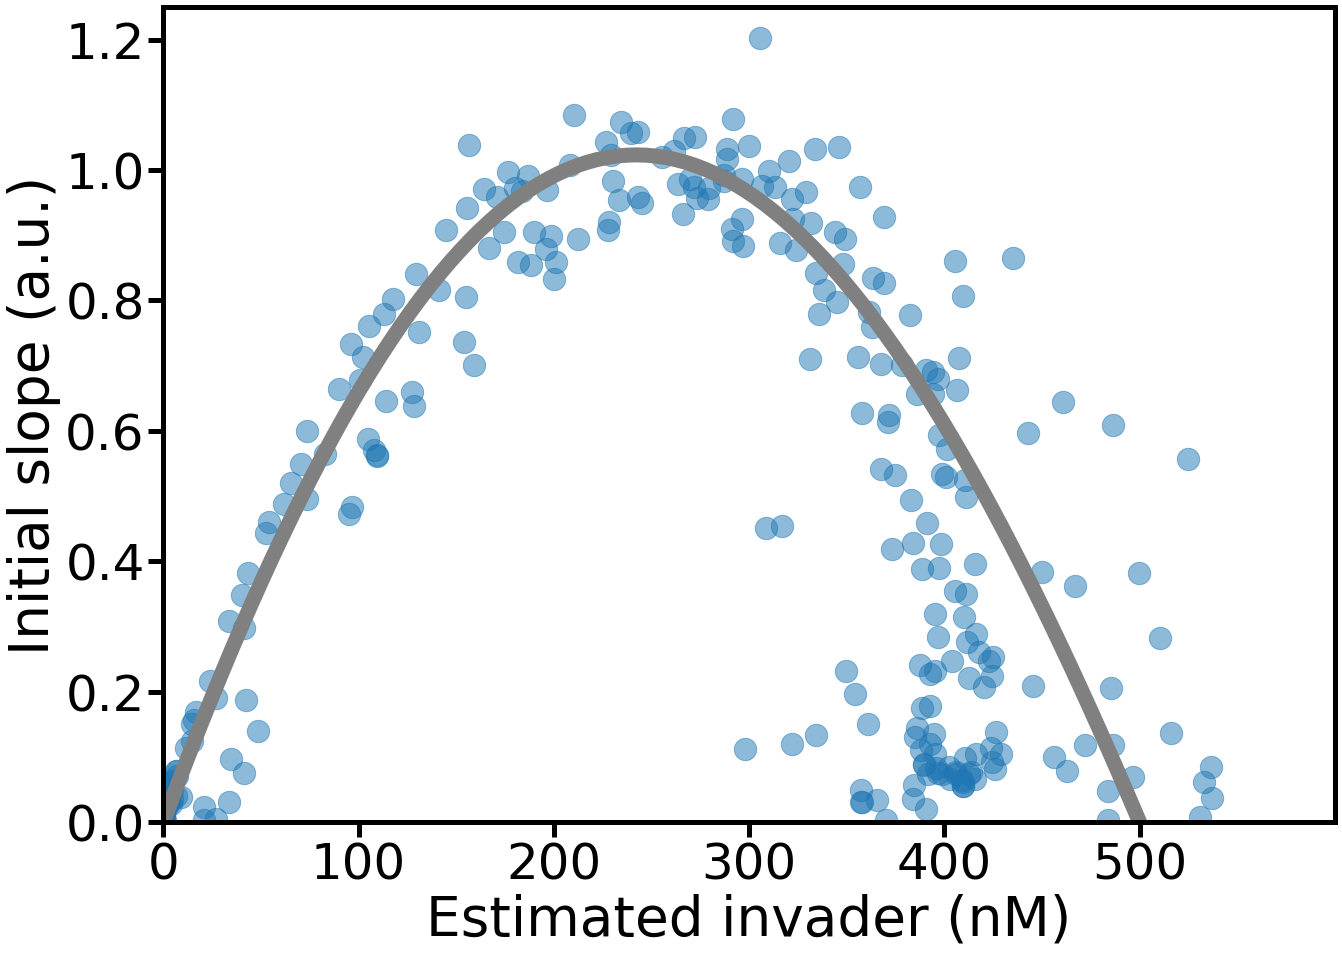

In [18]:

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the differential equations
def equations(y, t, k1):
    A, B, F = y
    dA_dt = -k1*A*B
    dB_dt = -k1*A*B
    dF_dt = k1*A*B
    return [dA_dt, dB_dt, dF_dt]

# Define the constant
k1 = 2.68e-5

# Define the range of initial concentrations for A
A_initial = np.linspace(0, 500, 100)

# Define the time points for integration
t = np.linspace(0, 100,100)
slopes2 = []
slopes1 = []
# Loop over the range of initial concentrations for A and solve the differential equations for each case
for A0 in A_initial:
    B0 = (1 - A0/500)*400
    y0 = [A0, B0, 0]
    sol = odeint(equations, y0, t, args=(k1,))
    slope2 = ((sol[:,2][99]-sol[:,2][10])/90)*1.3
    slope1 = ((sol[:,2][99]-sol[:,2][10])/90)
    slopes2.append(slope2)
    slopes1.append(slope1)


# Plot the slopes
fig, ax = plt.subplots()
ax.plot(A_initial, slopes2, linewidth = 15, color='grey')

plt.scatter(LastGFP, slopes, color='tab:blue', alpha=0.5, s=500)
plt.xlabel('Estimated invader (nM)', fontsize=55)
plt.ylabel('Initial slope (a.u.)', fontsize=55)
plt.axis([0,600, 0, 1.25])
plt.xticks([0, 100, 200, 300, 400, 500], ['0', '100', '200', '300', '400', '500'])
plt.tick_params(axis='both', length=15, width=5)
plt.savefig("Concentration_vs_Slope.svg",dpi=100, format='svg')

In [19]:
X =[]
Y = []

for i in range(len(data_new)):
    X.append(data_new[i]['X'].iloc[-1])
    Y.append(data_new[i]['Y'].iloc[-1])

with open(r'X.txt', 'w') as fp:
    for item in X:
        fp.write("%s\n" % item)
    
with open(R'Y.txt', 'w') as fp:
    for item in Y:
        fp.write("%s\n" % item)

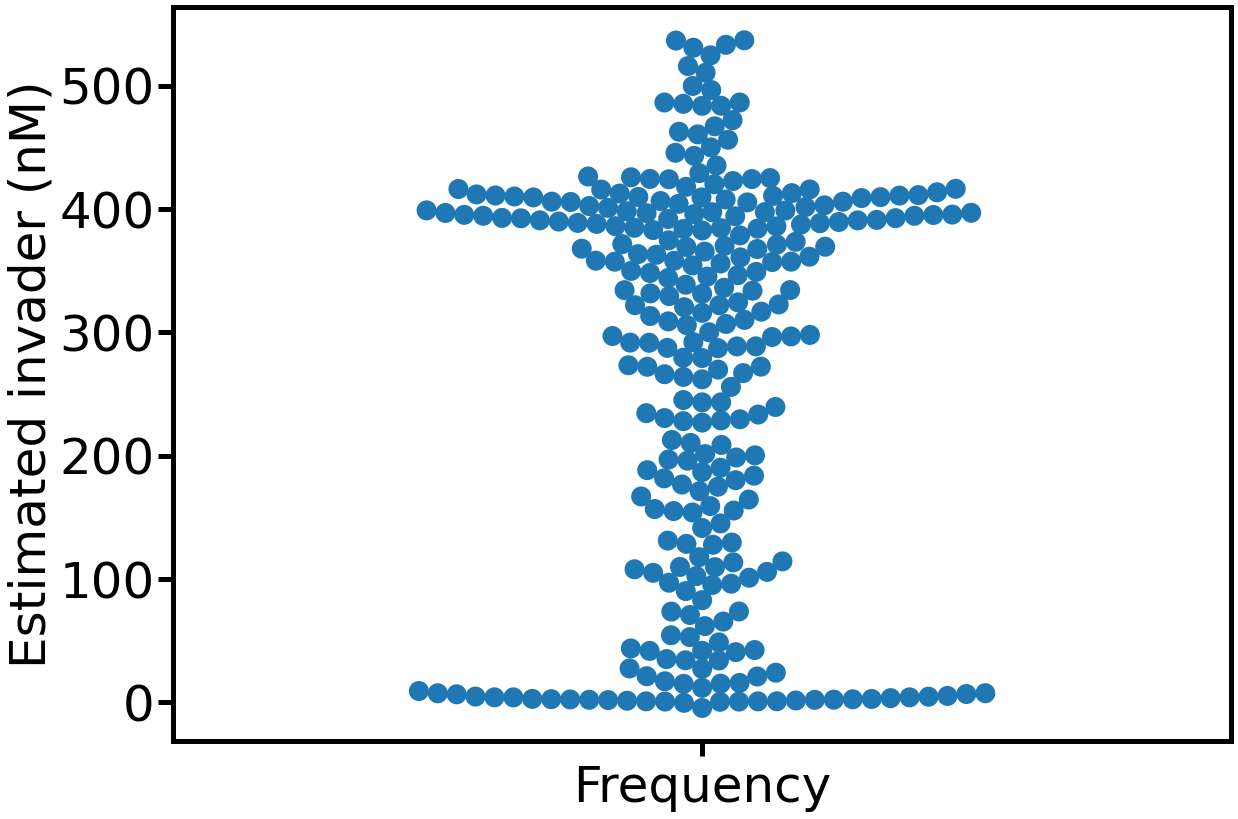

In [20]:
ax = sns.swarmplot(y=LastGFP, size=20, color='tab:blue')

plt.xlabel('Frequency', fontsize=50)
plt.ylabel('Estimated invader (nM)', fontsize=50)
#ax.set_ylim(0, 5)
plt.tick_params(axis='both', length=15, width=5)
plt.yticks([0, 100, 200, 300, 400, 500], ['0', '100', '200', '300', '400', '500'])
#plt.title('Swarmplots GFP value', fontsize=50)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)
plt.savefig("Estimated_Invader.svg",dpi=100, format='svg')

# show plot
plt.show()